<a href="https://colab.research.google.com/github/kmouleejunhyuk/windturbine/blob/main/windturbine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 풍력발전기 상태이상 판별 과제

In [1]:
###
#python, pytorch
#data not encluded due to copyrights issue

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

import sys
import time
import random

In [3]:
#구글 드라이브 마운트 & 경로설정
from google.colab import drive
drive.mount('/gdrive')

PATH='/gdrive/My Drive/windturbine'

Mounted at /gdrive


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("using device: ", device)

using device:  cuda


In [5]:
#seed for reproducability
random_seed=49   #44159
torch.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)

#### Data loading and EDA

In [6]:
#data import
train_raw=pd.read_csv(PATH+'/training_data_set.csv')
test_raw=pd.read_csv(PATH+'/validation_data_set.csv')

In [7]:
#EDA helper function
def EDA(df: pd.DataFrame):
    print(df.head(), '\n')
    print(df.dtypes, '\n')

    for _ in df.columns:
        if df[_].isna().sum() != 0 or df[_].dtypes != 'float64':
            #static information
            print('column '+ _ + ' static info')
            print('max:', '\t\t', df[_].max())
            print('min:', '\t\t', df[_].min())
            print('avg:', '\t\t', df[_].mean())
            print('count of na: ', '\t\t', df[_].isna().sum())
            print('unique values: ', '\t\t', df[_].nunique(dropna=False))

            #plot boxplot by column
            source=df[_].copy()
            plt.rcParams['figure.figsize']=[10, 6]
            plt.title(_)
            plt.boxplot(source, notch=1, sym='rs', vert=0)
            plt.show()
            plt.close()
            print('\n')

        #else: print('no na and float value in column {}. max: {}, min: {}, avg: {} \n'.format(_, df[_].max(), df[_].min(), df[_].mean()))

          1         2    3    4         5  ...  682  683  684  685  686
0  0.621211  0.771822  0.5  0.5  0.618948  ...    0    0    0    0    1
1  0.624648  0.319315  0.5  0.5  0.625634  ...    0    0    0    0    1
2  0.625174  0.244754  0.5  0.5  0.626474  ...    0    0    0    0    1
3  0.628112  0.266645  0.5  0.5  0.627791  ...    0    0    0    0    1
4  0.629918  0.204191  0.5  0.5  0.629838  ...    0    0    0    0    1

[5 rows x 686 columns] 

1      float64
2      float64
3      float64
4      float64
5      float64
        ...   
682      int64
683      int64
684      int64
685      int64
686      int64
Length: 686, dtype: object 

column 681 static info
max: 		 1
min: 		 0
avg: 		 0.1825
count of na:  		 0
unique values:  		 2


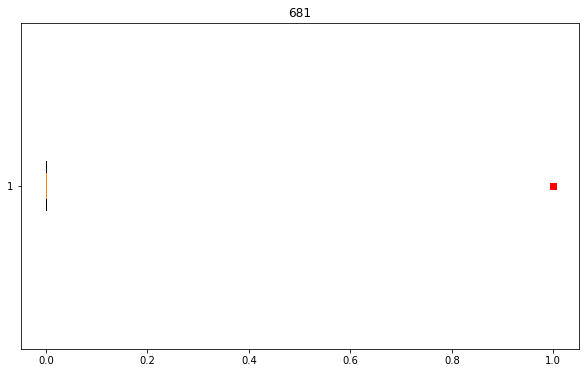



column 682 static info
max: 		 1
min: 		 0
avg: 		 0.1825
count of na:  		 0
unique values:  		 2


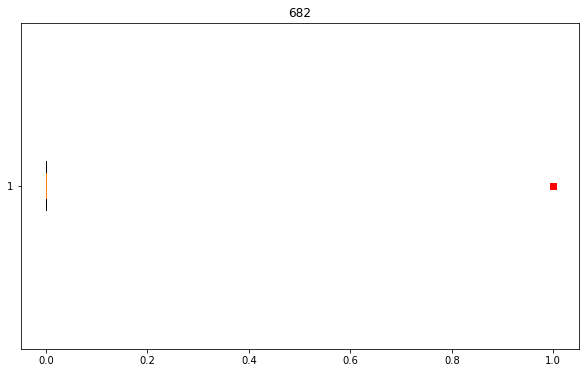



column 683 static info
max: 		 1
min: 		 0
avg: 		 0.14625
count of na:  		 0
unique values:  		 2


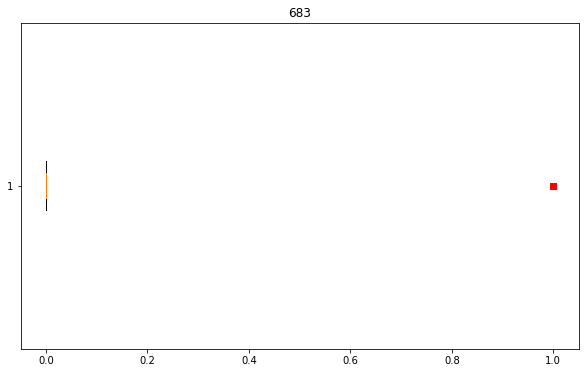



column 684 static info
max: 		 1
min: 		 0
avg: 		 0.1625
count of na:  		 0
unique values:  		 2


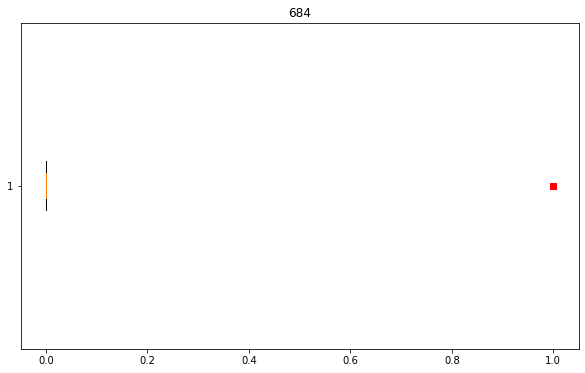



column 685 static info
max: 		 1
min: 		 0
avg: 		 0.16375
count of na:  		 0
unique values:  		 2


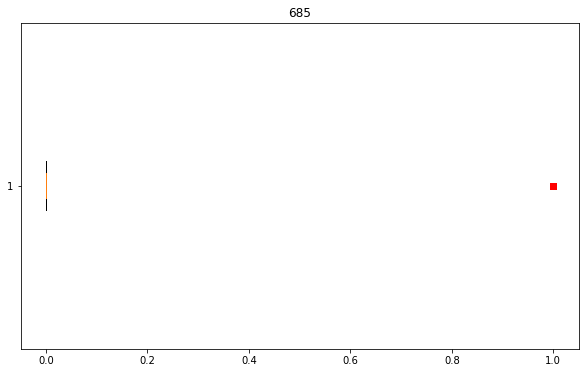



column 686 static info
max: 		 1
min: 		 0
avg: 		 0.1625
count of na:  		 0
unique values:  		 2


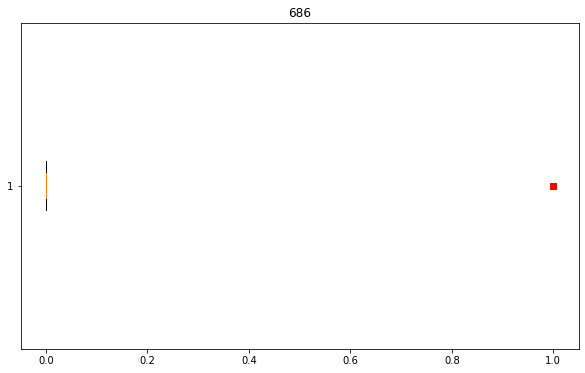

In [8]:
EDA(train_raw)

          1         2    3    4         5  ...  682  683  684  685  686
0  1.019280  1.240127  0.5  0.5  1.018462  ...    0    0    0    0    1
1  1.019262  1.248247  0.5  0.5  1.018890  ...    0    0    0    0    1
2  1.023792  1.286444  0.5  0.5  1.024392  ...    0    0    0    0    1
3  1.023431  1.364974  0.5  0.5  1.023545  ...    0    0    0    0    1
4  1.018795  1.277456  0.5  0.5  1.021053  ...    0    0    0    0    1

[5 rows x 686 columns] 

1      float64
2      float64
3      float64
4      float64
5      float64
        ...   
682      int64
683      int64
684      int64
685      int64
686      int64
Length: 686, dtype: object 

column 681 static info
max: 		 1
min: 		 0
avg: 		 0.19
count of na:  		 0
unique values:  		 2


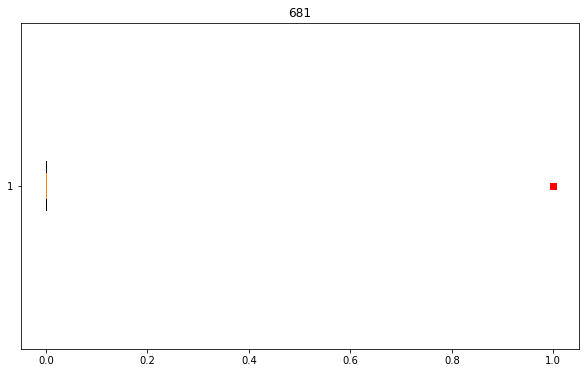



column 682 static info
max: 		 1
min: 		 0
avg: 		 0.13
count of na:  		 0
unique values:  		 2


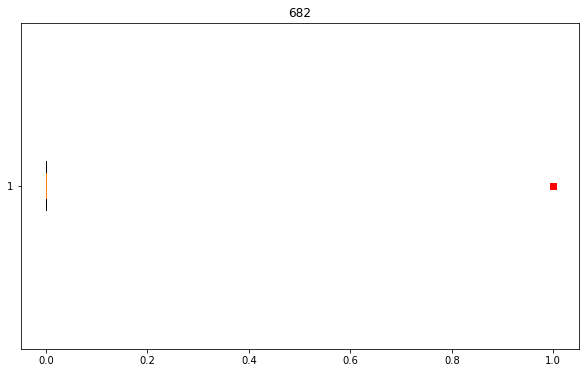



column 683 static info
max: 		 1
min: 		 0
avg: 		 0.19
count of na:  		 0
unique values:  		 2


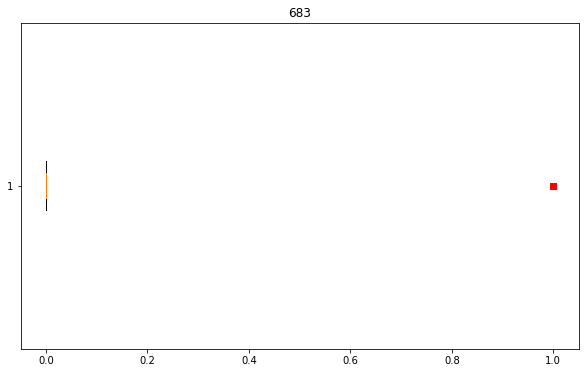



column 684 static info
max: 		 1
min: 		 0
avg: 		 0.13
count of na:  		 0
unique values:  		 2


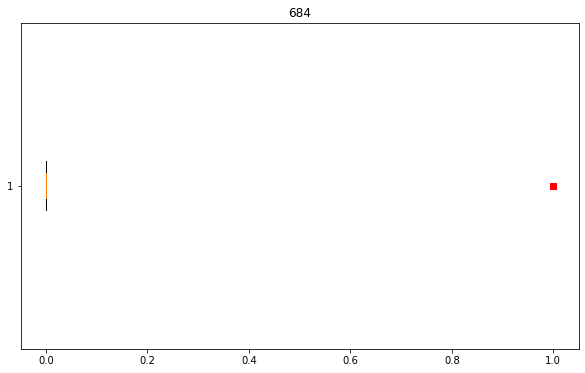



column 685 static info
max: 		 1
min: 		 0
avg: 		 0.22
count of na:  		 0
unique values:  		 2


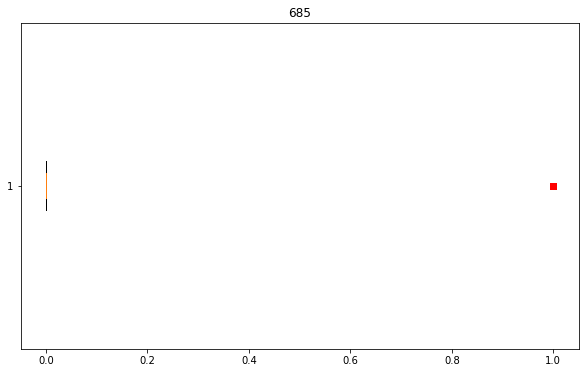



column 686 static info
max: 		 1
min: 		 0
avg: 		 0.14
count of na:  		 0
unique values:  		 2


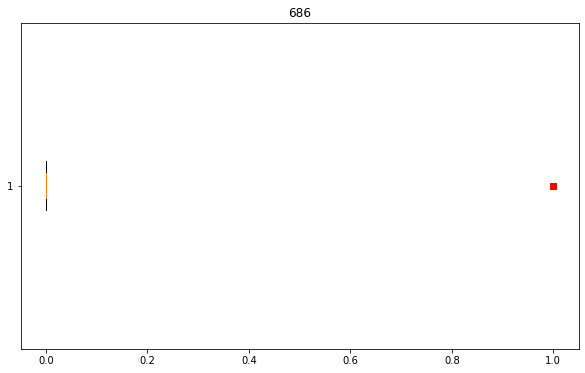

In [9]:
EDA(test_raw)

In [10]:
##column 681~686 seems to be one-hot encoded target value

#### preparing data

In [ ]:
train_raw=train_raw.sample(frac=1).reset_index(drop=True)

row=train_raw.shape[0]
train=train_raw.iloc[:int(row*0.8)]
valid=train_raw.iloc[int(row*0.8):]

In [11]:
y_train=train[[str(x) for x in range(681, 687)]]
x_train=train[[str(x) for x in range(1, 681)]]

y_valid=valid[[str(x) for x in range(681, 687)]]
x_valid=valid[[str(x) for x in range(1, 681)]]

y_test=test_raw[[str(x) for x in range(681, 687)]]
x_test=test_raw[[str(x) for x in range(1, 681)]]

In [12]:
y_train.iloc[0]

681    0
682    0
683    0
684    0
685    0
686    1
Name: 0, dtype: int64

In [13]:
#changing one-hot encoded target value to single integer value(0~6)
y_train['target']=np.argmax(y_train.copy().values, axis=1)
y_valid['target']=np.argmax(y_valid.copy().values, axis=1)
y_test['target']=np.argmax(y_test.copy().values, axis=1)

y_train=y_train['target'].copy()
y_valid=y_valid['target'].copy()
y_test=y_test['target'].copy()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [14]:
np.unique(y_test.values, return_counts=True)

(array([0, 1, 2, 3, 4, 5]), array([3800, 2600, 3800, 2600, 4400, 2800]))

In [15]:
#from sklearn.preprocessing import RobustScaler
#trans=RobustScaler().fit(x_train.values)
#x_train=pd.DataFrame(data=trans.transform(x_train.values), columns=x_train.columns)
#x_test=pd.DataFrame(data=trans.transform(x_test.values), columns=x_test.columns)

In [16]:
x_train

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671,672,673,674,675,676,677,678,679,680
0,0.621211,0.771822,0.500000,0.500000,0.618948,0.778204,0.500000,0.500000,0.618757,0.781689,0.500000,0.500000,0.620138,0.779829,0.500000,0.500000,0.620462,0.780373,0.500000,0.500000,0.621198,0.782671,0.500000,0.500000,0.621067,0.785016,0.500000,0.500000,0.620831,0.787296,0.500000,0.500000,0.621668,0.787148,0.500000,0.500000,0.621921,0.788640,0.500000,0.500000,...,0.623611,0.905358,0.500000,0.500000,0.624826,0.900685,0.500000,0.500000,0.626593,0.891782,0.500000,0.500000,0.624835,0.889028,0.500000,0.500000,0.624248,0.888958,0.500000,0.500000,0.625558,0.882536,0.500000,0.500000,0.625394,0.876826,0.500000,0.500000,0.626826,0.869474,0.500000,0.500000,0.626368,0.865372,0.500000,0.500000,0.627538,0.858994,0.500000,0.500000
1,0.624648,0.319315,0.500000,0.500000,0.625634,0.322292,0.500000,0.500000,0.624609,0.327090,0.500000,0.500000,0.626457,0.329370,0.500000,0.500000,0.625968,0.333533,0.500000,0.500000,0.626370,0.337926,0.500000,0.500000,0.626663,0.341066,0.500000,0.500000,0.625799,0.346628,0.500000,0.500000,0.625098,0.352255,0.500000,0.500000,0.625129,0.356953,0.500000,0.500000,...,0.623302,0.308619,0.500000,0.500000,0.623672,0.308181,0.500000,0.500000,0.623901,0.309154,0.500000,0.500000,0.624576,0.309127,0.500000,0.500000,0.624481,0.308304,0.500000,0.500000,0.623694,0.308501,0.500000,0.500000,0.624821,0.307455,0.500000,0.500000,0.624925,0.306996,0.500000,0.500000,0.624853,0.305456,0.500000,0.500000,0.625327,0.302547,0.500000,0.500000
2,0.625174,0.244754,0.500000,0.500000,0.626474,0.244188,0.500000,0.500000,0.625647,0.246693,0.500000,0.500000,0.625275,0.249789,0.500000,0.500000,0.627041,0.250458,0.500000,0.500000,0.627897,0.251795,0.500000,0.500000,0.628201,0.254106,0.500000,0.500000,0.629351,0.255358,0.500000,0.500000,0.629306,0.258078,0.500000,0.500000,0.628768,0.261649,0.500000,0.500000,...,0.627046,0.311573,0.500000,0.500000,0.628475,0.307589,0.500000,0.500000,0.627504,0.307001,0.500000,0.500000,0.625525,0.308530,0.500000,0.500000,0.627830,0.304099,0.500000,0.500000,0.629147,0.300355,0.500000,0.500000,0.629372,0.300141,0.500000,0.500000,0.629461,0.300074,0.500000,0.500000,0.628376,0.301380,0.500000,0.500000,0.628752,0.300429,0.500000,0.500000
3,0.628112,0.266645,0.500000,0.500000,0.627791,0.265395,0.500000,0.500000,0.628627,0.263789,0.500000,0.500000,0.629278,0.261797,0.500000,0.500000,0.629657,0.259154,0.500000,0.500000,0.627763,0.260061,0.500000,0.500000,0.628397,0.260353,0.500000,0.500000,0.627545,0.261335,0.500000,0.500000,0.628393,0.260832,0.500000,0.500000,0.629446,0.259423,0.500000,0.500000,...,0.631336,0.099245,0.500000,0.500000,0.630362,0.097601,0.500000,0.500000,0.629374,0.096301,0.500000,0.500000,0.630424,0.093527,0.500000,0.500000,0.629666,0.092425,0.500000,0.500000,0.629122,0.091365,0.500000,0.500000,0.628671,0.089794,0.500000,0.500000,0.628528,0.087847,0.500000,0.500000,0.627578,0.086856,0.500000,0.500000,0.626935,0.085965,0.500000,0.500000
4,0.629918,0.204191,0.500000,0.500000,0.629838,0.200329,0.500000,0.500000,0.630213,0.196088,0.500000,0.500000,0.629504,0.193500,0.500000,0.500000,0.628963,0.190968,0.500000,0.500000,0.628110,0.188250,0.500000,0.500000,0.628142,0.185221,0.500000,0.500000,0.627405,0.183282,0.500000,0.500000,0.626792,0.182338,0.500000,0.500000,0.627162,0.178896,0.500000,0.500000,...,0.627253,0.064991,0.500000,0.500000,0.626697,0.066175,0.500000,0.500000,0.626166,0.066714,0.500000,0.500000,0.625903,0.066971,0.500000,0.500000,0.624765,0.067522,0.500000,0.500000,0.625170,0.066490,0.500000,0.500000,0.623686,0.066064,0.500000,0.500000,0.623665,0.065208,0.500000,0.500000,0.622915,0.064237,0.500000,0.500000,0.623839,0.061642,0.500000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,..

#### dataloader

In [17]:
class windturbine_Dataset(Dataset):
    def __init__(self, x: np.array, y: np.array):
        self.x = x
        self.y = y
        

    def __getitem__(self, i):
        return (self.x[i] , self.y[i])

    def __len__(self):
        return (len(self.y))

In [18]:
x_train.shape[0]

80000

In [19]:
batch_size=x_train.shape[0]

train_dataset=windturbine_Dataset(x_train.values, y_train.values)
valid_dataset=windturbine_Dataset(x_valid.values, y_valid.values)
test_dataset=windturbine_Dataset(x_test.values, y_test.values)


train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=5)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=5)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=5)

#### model

In [45]:
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1_1=torch.nn.Linear(680, 512)
        self.fc1_2=torch.nn.Linear(512, 256)
        self.fc1_3=torch.nn.Linear(256, 64)

        self.fc2_1=torch.nn.Linear(680, 256)
        self.fc2_2=torch.nn.Linear(256, 128)
        self.fc2_3=torch.nn.Linear(128, 64)

        self.fc3_1=torch.nn.Linear(680, 1024)
        self.fc3_2=torch.nn.Linear(1024, 1024)
        self.fc3_3=torch.nn.Linear(1024, 64)

        self.fc_full_1=torch.nn.Linear(192, 128)
        self.fc_full_2=torch.nn.Linear(128, 64)
        self.fc_full_3=torch.nn.Linear(64, 6)

    def forward(self, x):
        x1=self.fc1_1(x)
        x1=F.relu(x1)
        x1=self.fc1_2(x1)
        x1=F.relu(x1)
        x1=self.fc1_3(x1)
        x1=F.relu(x1)

        x2=self.fc2_1(x)
        x2=F.relu(x2)
        x2=self.fc2_2(x2)
        x2=F.relu(x2)
        x2=self.fc2_3(x2)
        x2=F.relu(x2)

        x3=self.fc3_1(x)
        x3=F.relu(x3)
        x3=self.fc3_2(x3)
        x3=F.relu(x3)
        x3=self.fc3_3(x3)
        x3=F.relu(x3)


        x=torch.cat((x1, x2, x3), dim=1)
        x=self.fc_full_1(x)
        x=F.relu(x)
        x=self.fc_full_2(x)
        x=F.relu(x)
        x=self.fc_full_3(x)

        return x

model=Net().to(device)

In [46]:
#accuracy 계산 함수
def calc_accuracy(X,Y):
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

#### training session

In [52]:
#hyperparameters
learning_rate=1e-3
num_epochs=3000
log_interval=50

In [48]:

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

#t_total = len(train_dataloader) * num_epochs
#warmup_step = int(t_total * warmup_ratio)
#scheduler = WarmupLinearSchedule(optimizer, warmup_steps=warmup_step, t_total=t_total)

In [ ]:
#이후 모델 파일명 및 submission에 사용하기 위한 변수 선언
answer=[]
acc=0
#starttime=0
#학습 시작
for e in range(num_epochs):
    train_acc = 0.0
    valid_acc = 0.0
    model.train()
    for batch_id, (x_batch, y_batch) in enumerate(train_dataloader):
        
        optimizer.zero_grad()
        x_batch = x_batch.float().to(device)
        y_batch = y_batch.long().to(device)
        out = model(x_batch)
        loss = loss_fn(out, y_batch)
        loss.backward()
        #torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        #scheduler.step()  
        train_acc += calc_accuracy(out, y_batch)
        #if batch_id % log_interval == 0 and batch_id != 0:
         #   print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    if e%log_interval == 0:
        print("epoch {} train acc {}".format(e+1, train_acc / (batch_id+1)))
        '''
        model.eval()
        for batch_id, (x_batch, y_batch) in enumerate(valid_dataloader):
            with torch.no_grad():
                x_batch = x_batch.float().to(device)
                y_batch = y_batch.long().to(device)
                out = model(x_batch)
                valid_acc += calc_accuracy(out, y_batch)

            print("\tvalid acc {}".format(valid_acc))
        '''

In [ ]:
!nvidia-smi

Tue Feb 23 13:44:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   75C    P0    33W /  70W |   1376MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#평가 부분 작성